# Estimating Likelihood with Logisitic Regression

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn import feature_selection,preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from patsy import dmatrices


### Titanic Data

We are going to use the data form the Titanic Dataset from Kaggle to train various classification models. 

Before continuing, make sure you have completed the exercises from the TitanicEDA.ipynb file

VARIABLE DESCRIPTIONS:
* <b>survival</b>        Survival (0 = No; 1 = Yes)
* <b>pclass</b>          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* <b>name</b>            Name
* <b>sex</b>             Sex
* <b>age</b>             Age
* <b>sibsp</b>           Number of Siblings/Spouses Aboard
* <b>parch</b>           Number of Parents/Children Aboard
* <b>ticket</b>          Ticket Number
* <b>fare</b>            Passenger Fare
* <b>cabin</b>           Cabin
* <b>embarked</b>        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


### Inputting the data 

In [2]:
df = pd.read_csv('titanic_data.csv')

df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Counting the missing values in each column

In [4]:
len(df)

891

In [5]:
df.count(0)

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Ticket and Cabin column won't add much value to the model building process as the ticket column is the unique identifier for each passenger (similar to name) and the Cabin column is mostly empty.

We'll remove these two columns from our dataframe

In [6]:
df = df.drop(['PassengerId','Ticket','Cabin','Name'], axis=1)

# Remove missing values
df = df.dropna() 

df.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000
mean     0.404494    2.240169   29.642093    0.514045    0.432584   34.567251
std      0.491139    0.836854   14.492933    0.930692    0.854181   52.938648
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    1.000000   20.000000    0.000000    0.000000    8.050000
50%      0.000000    2.000000   28.000000    0.000000    0.000000   15.645850
75%      1.000000    3.000000   38.000000    1.000000    1.000000   33.000000
max      1.000000    3.000000   80.000000    5.000000    6.000000  512.329200

In [7]:
df.count(0)

Survived    712
Pclass      712
Sex         712
Age         712
SibSp       712
Parch       712
Fare        712
Embarked    712
dtype: int64

## Model Building

Assuming there is no temporary bias in the data, we can split the into training and testing set with iloc

In [8]:

df_train = df.iloc[ 0: 600, : ]
df_test = df.iloc[ 600: , : ]



In [9]:
print(len(df_train))
print(len(df_test))

600
112


Statsmodel also allows for glm models. We can build a logisitc regression model using statsmodel

In [10]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked) +  Parch' 

y_train,x_train = dmatrices(formula, data=df_train, return_type='dataframe')
y_test,x_test = dmatrices(formula, data=df_test, return_type='dataframe')

# instantiate our model
model = sm.Logit(y_train,x_train)
res = model.fit()
res.summary()


Optimization terminated successfully.
         Current function value: 0.450031
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  600
Model:                          Logit   Df Residuals:                      591
Method:                           MLE   Df Model:                            8
Date:                Fri, 17 May 2019   Pseudo R-squ.:                  0.3333
Time:                        20:56:57   Log-Likelihood:                -270.02
converged:                       True   LL-Null:                       -404.99
                                        LLR p-value:                 1.009e-53
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.3332      0.510      8.490      0.000       3.333       5.334
C(Pclass)[T.2]      -1.2030      0.325     -3.703      0.000      -1.840      -0.566
C(Pclass)[T.3]      -2.4673      0.320     -7.705      0.000      -3.095      -1.840
C(Sex)[T.male]      -2.6312      0.244    -10.797      0.000      -3.109      -2.154
C(Embarked)[T.Q]    -0.4359      0.647     -0.674      0.501      -1.704       0.832
C(Embarked)[T.S]    -0.2910      0.297     -0.980      0.327      -0.873       0.291
Age                 -0.0397      0.009     -4.464      0.000      -0.057      -0.022
SibSp               -0.3202      0.136     -2.354      0.019      -0.587      -0.054
Parch               -0.1420      0.136     -1.041      0.298      -0.409       0.125
====================================================================================
"""

Pseudo R values of 0.2 - 0.4 are acceptable but let's see if we can improve it remodeling based on the significant variables

In [11]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp ' 

y_train,x_train = dmatrices(formula, data=df_train, return_type='dataframe')
y_test,x_test = dmatrices(formula, data=df_test, return_type='dataframe')

# instantiate our model
model = sm.Logit(y_train,x_train)
res = model.fit()
res.summary()


Optimization terminated successfully.
         Current function value: 0.451793
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  600
Model:                          Logit   Df Residuals:                      594
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 May 2019   Pseudo R-squ.:                  0.3307
Time:                        21:08:45   Log-Likelihood:                -271.08
converged:                       True   LL-Null:                       -404.99
                                        LLR p-value:                 8.172e-56
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.1050      0.479      8.575      0.000       3.167       5.043
C(Pclass)[T.2]    -1.2971      0.306     -4.242      0.000      -1.896      -0.698
C(Pclass)[T.3]    -2.5739      0.305     -8.433      0.000      -3.172      -1.976
C(Sex)[T.male]    -2.5808      0.235    -10.996      0.000      -3.041      -2.121
Age               -0.0401      0.009     -4.549      0.000      -0.057      -0.023
SibSp             -0.3691      0.130     -2.840      0.005      -0.624      -0.114
==================================================================================
"""

Lets see prediction distribution 

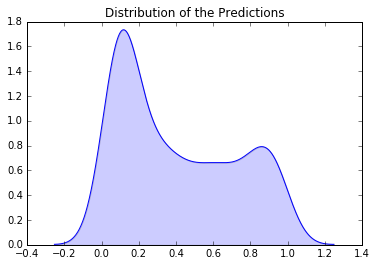

In [45]:
import warnings
warnings.filterwarnings('ignore')

kde_res = KDEUnivariate(res.predict())
kde_res.fit()
plt.plot(kde_res.support,kde_res.density)
plt.fill_between(kde_res.support,kde_res.density, alpha=0.2)
plt.title("Distribution of the Predictions")
plt.show()

Distribution of prediction based on the Gender

In [ ]:
plt.scatter(res.predict(),x_train['C(Sex)[T.male]'] , alpha=0.2)
plt.grid(b=True, which='major', axis='x')
plt.xlabel("Predicted chance of survival")
plt.ylabel("Male Gender")
plt.title("The Change of Survival Probability by Gender being Male")

Distribution of the prediction based on the lower class

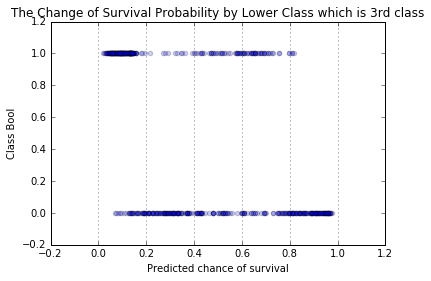

In [11]:
plt.scatter(res.predict(),x_train['C(Pclass)[T.3]'] , alpha=0.2)
plt.xlabel("Predicted chance of survival")
plt.ylabel("Class Bool")
plt.grid(b=True, which='major', axis='x')
plt.title("The Change of Survival Probability by Lower Class which is 3rd class")

Distribution of prediction based on Age

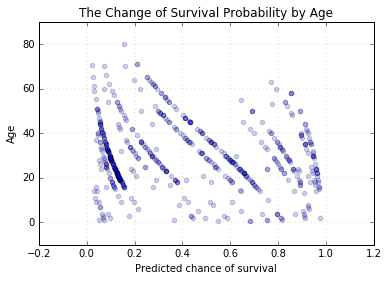

In [12]:
plt.scatter(res.predict(),x_train.Age , alpha=0.2)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Age")
plt.xlabel("Predicted chance of survival")
plt.ylabel("Age")

Distribution of prediction based on number of siblings

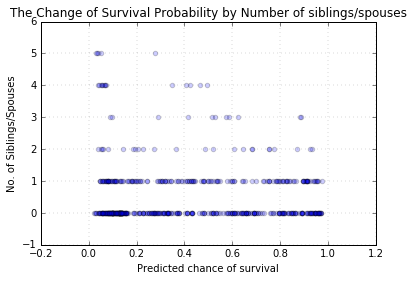

In [13]:
plt.scatter(res.predict(),x_train.SibSp , alpha=0.2)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Number of siblings/spouses")
plt.xlabel("Predicted chance of survival")
plt.ylabel("No. of Siblings/Spouses")

The graphs helps us communicate results but in this case they are hard to understand. We can use the test data to see how is the performance of the model throught the precision and recall by keeping a threshold of 0.7

In [14]:
y_pred = res.predict(x_test)
y_pred_flag = y_pred > 0.7
print (pd.crosstab(y_test.Survived
                  ,y_pred_flag
                  ,rownames = ['Actual']
                  ,colnames = ['Predicted']))

print ('\n \n')

print (classification_report(y_test,y_pred_flag))

Predicted  False  True 
Actual                 
0.0           67      0
1.0           21     24

 

             precision    recall  f1-score   support

        0.0       0.76      1.00      0.86        67
        1.0       1.00      0.53      0.70        45

avg / total       0.86      0.81      0.80       112



Let's compute the receiver operating characteristics

In [15]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print ("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.879934


Let's plot the roc curve

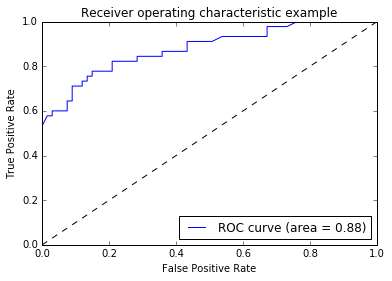

In [16]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Let's build the same model using scikit 

In [17]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(x_train, y_train.Survived)


In [18]:
# examine the coefficients
pd.DataFrame(list(zip(x_train.columns, np.transpose(model.coef_))))

0                   1
0       Intercept     [1.67901055169]
1  C(Pclass)[T.2]   [-0.941153850136]
2  C(Pclass)[T.3]    [-2.13935206338]
3  C(Sex)[T.male]    [-2.34378495972]
4             Age  [-0.0314323296385]
5           SibSp   [-0.297688752633]

Let's check out the precision and recall for it

In [19]:
y_pred = model.predict_proba(x_test)
y_pred_flag = y_pred[:,1] > 0.7


print (pd.crosstab(y_test.Survived
                  ,y_pred_flag
                  ,rownames = ['Actual']
                  ,colnames = ['Predicted']))

print ('\n \n')

print (classification_report(y_test,y_pred_flag))

Predicted  False  True 
Actual                 
0.0           67      0
1.0           23     22

 

             precision    recall  f1-score   support

        0.0       0.74      1.00      0.85        67
        1.0       1.00      0.49      0.66        45

avg / total       0.85      0.79      0.77       112



Let's compute the roc curve

In [20]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.878275


Let's plot the roc curve

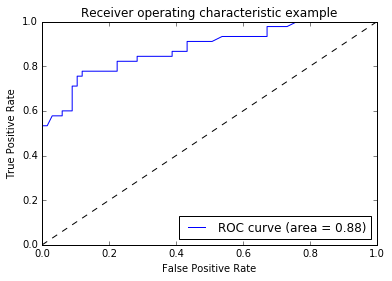

In [21]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Decision Tress
Training a decision tree in scikit follows the same instantiation-fitting-evaluating cycle (only requirement is that all the variables need to be numeric)

In [22]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [23]:
df["Sex"] = df["Sex"].apply(lambda sex: 0 if sex == 'male' else 1)

y = targets = labels = df["Survived"].values

columns = ["Fare", "Pclass", "Sex", "Age", "SibSp"]
features = df[list(columns)].values
features

array([[  7.25  ,   3.    ,   0.    ,  22.    ,   1.    ],
       [ 71.2833,   1.    ,   1.    ,  38.    ,   1.    ],
       [  7.925 ,   3.    ,   1.    ,  26.    ,   0.    ],
       ..., 
       [ 30.    ,   1.    ,   1.    ,  19.    ,   0.    ],
       [ 30.    ,   1.    ,   0.    ,  26.    ,   0.    ],
       [  7.75  ,   3.    ,   0.    ,  32.    ,   0.    ]])

To remove the nan values we impute them the mean of the column

In [24]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(features)
X

array([[  7.25  ,   3.    ,   0.    ,  22.    ,   1.    ],
       [ 71.2833,   1.    ,   1.    ,  38.    ,   1.    ],
       [  7.925 ,   3.    ,   1.    ,  26.    ,   0.    ],
       ..., 
       [ 30.    ,   1.    ,   1.    ,  19.    ,   0.    ],
       [ 30.    ,   1.    ,   0.    ,  26.    ,   0.    ],
       [  7.75  ,   3.    ,   0.    ,  32.    ,   0.    ]])

In [25]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X, y)

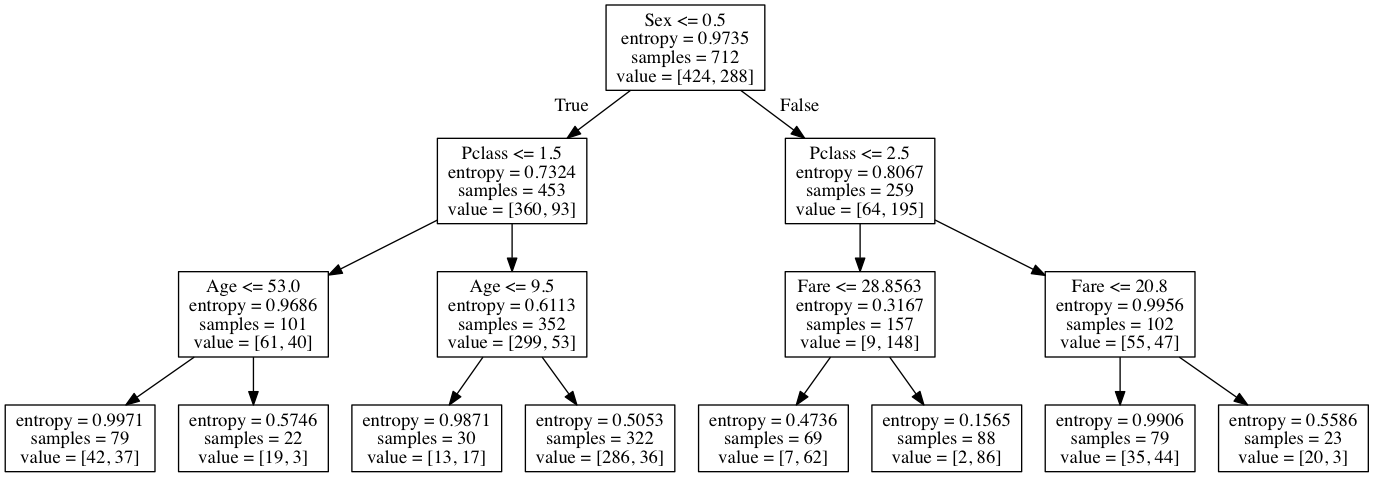

In [35]:
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO

#install pydotplus conda install -c conda-forge pydotplus
# install graphviz conda install graphviz

dot_data= StringIO() 
export_graphviz(clf, out_file=dot_data,feature_names=columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("tree.png")

from IPython.display import Image
Image(filename='tree.png') 